<a href="https://colab.research.google.com/github/shahuzi/tf2.0_learning/blob/master/1_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.2.0
Eager mode:  True
Hub version:  0.8.0
GPU is NOT AVAILABLE


In [0]:
# 将训练集分割成 60% 和 40%，从而最终我们将得到 15,000 个训练样本
# 10,000 个验证样本以及 25,000 个测试样本。
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

In [4]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [5]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

# 构建模型

神经网络由堆叠的层来构建，这需要从三个主要方面来进行体系结构决策：

* 如何表示文本？
* 模型里有多少层？
* 每个层里有多少*隐层单元（hidden units）*？

本示例中，输入数据由句子组成。预测的标签为 0 或 1。

表示文本的一种方式是将句子转换为嵌入向量（embeddings vectors）。我们可以使用一个预先训练好的文本嵌入（text embedding）作为首层，这将具有三个优点：

* 我们不必担心文本预处理
* 我们可以从迁移学习中受益
* 嵌入具有固定长度，更易于处理

针对此示例我们将使用 [TensorFlow Hub](https://www.tensorflow.org/hub) 中名为 [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1) 的一种**预训练文本嵌入（text embedding）模型** 。

为了达到本教程的目的还有其他三种预训练模型可供测试：

* [google/tf2-preview/gnews-swivel-20dim-with-oov/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) ——类似 [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1)，但 2.5%的词汇转换为未登录词桶（OOV buckets）。如果任务的词汇与模型的词汇没有完全重叠，这将会有所帮助。
* [google/tf2-preview/nnlm-en-dim50/1](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1) ——一个拥有约 1M 词汇量且维度为 50 的更大的模型。
* [google/tf2-preview/nnlm-en-dim128/1](https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1) ——拥有约 1M 词汇量且维度为128的更大的模型。

让我们首先创建一个使用 Tensorflow Hub 模型嵌入（embed）语句的Keras层，并在几个输

---

入样本中进行尝试。请注意无论输入文本的长度如何，嵌入（embeddings）输出的形状都是：`(num_examples, embedding_dimension)`。

In [6]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding,input_shape=[],dtype=tf.string,trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

In [7]:
# 现在让我们构建完整模型：
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


层按顺序堆叠以构建分类器：

1. 第一层是 Tensorflow Hub 层。这一层使用一个预训练的保存好的模型来将句子映射为嵌入向量（embedding vector）。我们所使用的预训练文本嵌入（embedding）模型([google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1))将句子切割为符号，嵌入（embed）每个符号然后进行合并。最终得到的维度是：`(num_examples, embedding_dimension)`。
2. 该定长输出向量通过一个有 16 个隐层单元的全连接层（`Dense`）进行管道传输。
3. 最后一层与单个输出结点紧密相连。使用 `Sigmoid` 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信水平。

让我们编译模型。

### 损失函数与优化器

一个模型需要损失函数和优化器来进行训练。由于这是一个二分类问题且模型输出概率值（一个使用 sigmoid 激活函数的单一单元层），我们将使用 `binary_crossentropy` 损失函数。

这不是损失函数的唯一选择，例如，您可以选择 `mean_squared_error` 。但是，一般来说 `binary_crossentropy` 更适合处理概率——它能够度量概率分布之间的“距离”，或者在我们的示例中，指的是度量 ground-truth 分布与预测值之间的“距离”。

稍后，当我们研究回归问题（例如，预测房价）时，我们将介绍如何使用另一种叫做均方误差的损失函数。

现在，配置模型来使用优化器和损失函数：

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 训练模型

以 512 个样本的 mini-batch 大小迭代 20 个 epoch 来训练模型。 这是指对 `x_train` 和 `y_train` 张量中所有样本的的 20 次迭代。在训练过程中，监测来自验证集的 10,000 个样本上的损失值（loss）和准确率（accuracy）：

In [9]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 3s 108ms/step - loss: 0.7080 - accuracy: 0.5912 - val_loss: 0.6510 - val_accuracy: 0.6184
Epoch 2/20
30/30 [==============================] - 3s 99ms/step - loss: 0.6211 - accuracy: 0.6442 - val_loss: 0.6023 - val_accuracy: 0.6591
Epoch 3/20
30/30 [==============================] - 3s 100ms/step - loss: 0.5754 - accuracy: 0.6791 - val_loss: 0.5650 - val_accuracy: 0.6872
Epoch 4/20
30/30 [==============================] - 3s 102ms/step - loss: 0.5347 - accuracy: 0.7138 - val_loss: 0.5293 - val_accuracy: 0.7151
Epoch 5/20
30/30 [==============================] - 3s 100ms/step - loss: 0.4951 - accuracy: 0.7470 - val_loss: 0.4950 - val_accuracy: 0.7385
Epoch 6/20
30/30 [==============================] - 3s 102ms/step - loss: 0.4569 - accuracy: 0.7750 - val_loss: 0.4637 - val_accuracy: 0.7757
Epoch 7/20
30/30 [==============================] - 3s 102ms/step - loss: 0.4201 - accuracy: 0.8052 - val_loss: 0.4341 - val_accuracy: 0.7855
Epoch 8

## 评估模型




我们来看下模型的表现如何。将返回两个值。损失值（loss）（一个表示误差的数字，值越低越好）与准确率（accuracy）。

In [10]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 3s - loss: 0.3127 - accuracy: 0.8633
loss: 0.313
accuracy: 0.863


In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

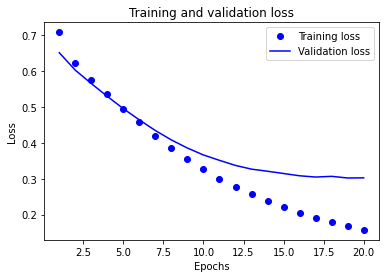

In [12]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

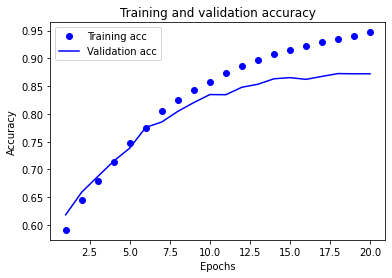

In [13]:
plt.clf()   # 清除数字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()